# 2. Optimisation (dealing with adaptive attacks)
use the pre-computed prediction for each sample ("sample_features.pkl") in optimisation. The pre-computed data is required.

In [1]:
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm, trange

sample_features = pd.read_pickle('sample_features.pkl')

my_systems = {
    'FaceNet':64.01,
    'r50':76.63,
    'EfficientNet':76.95,
    'ReXNet':76.29,
    'AttentionNet':74,
    'RepVGG':76.61,
    'GhostNet':77.78,
    'TF-NAS':75.86,
    'LightCNN':77.52
}

get_angle = lambda a, b: np.rad2deg(np.arccos((np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b) + 1e-7))))


In [2]:
sample_features = sample_features[~sample_features.index.duplicated(keep='first')]

In [3]:
pname = 'illumination'

In [4]:
my_perturbations = {'twonorm_10':[2318.00, 2587.00, 2495.00, 2748.00, 2729.00, 2675.00, 2595.00, 2722.00, 2910.00],
                    'infinity_4':[4502.00, 5933.00, 4807.00, 5886.00, 5806.00, 5937.00, 5810.00, 5515.00, 5980.00],
                    'glasses_7':[3764.00, 2354.00, 2619.00, 2433.00, 1635.00, 2373.00, 2592.00, 2207.00, 3600.00],
                    'age_20':[0.560833,0.615000,0.837500,0.859333,0.563167,0.872833,0.790000,0.776500,0.809667],
                    'pose_15':[0.481667,0.412500,0.698333,0.857500,0.427833,0.722500,0.687333,0.599833,0.734500],
                    'masked':[0.878000,0.955500,0.796833,0.820167,0.936833,0.829333,0.752000,0.849000,0.843667],
                    'barrel':[0.734000,0.893167,0.538333,0.526167,0.765667,0.541500,0.534833,0.538667,0.524500],
                    'illumination':[0.544333,0.884333,0.603000,0.648333,0.673167,0.663000,0.641500,0.640667,0.547333]
                   }

In [5]:
P_ = {}

for k, v in my_systems.items():
    
    P_[k] = {}
    
    for m1, m1_, m2, same in pd.read_csv(f'test_suite/{pname}.csv').values:


        i1 = sample_features[k][m1]
        i2 = sample_features[k][m2]
        i1_ = sample_features[k][m1_]

        y_pred = get_angle(i1, i2) < v
        y_pred_ = get_angle(i1_, i2) < v

        P_[k][m1, m1_, m2, same] = (y_pred == y_pred_)

df = pd.DataFrame(P_)

In [6]:
len(sample_features)

143732

In [7]:
from scipy import stats
import matplotlib.pyplot as plt

def show_crr(silver, bronze, *groups):

    ma = ['<', 'P', 'd']
    cl = ['#ff0000', '#0000ff', '#00ff00', '#000000']
    
    fig=plt.figure(figsize=(4,4), dpi= 100, facecolor='w', edgecolor='k')

    for i, g in enumerate(groups):
        plt.plot(g, silver[g], color=cl[i], marker=ma[i], ms=9, label=f"Group {i} silver")
        plt.plot(g, bronze[g], '-.', color=cl[i], marker=ma[i], ms=9, label=f"Group {i}: crr {stats.pearsonr(bronze[g], silver[g])[0]:.2f}")

    plt.xlabel("System ID")
    plt.ylabel("True Positive Rate")
    # plt.title(f"")
    plt.legend()
    plt.show()
    return stats.pearsonr(bronze[groups[0]], silver[groups[0]])[0]


In [8]:
known_robustness = np.array(my_perturbations[pname])
known_robustness = (known_robustness - known_robustness.min())/ (known_robustness.max() - known_robustness.min())
known_robustness

array([0.        , 1.        , 0.17255   , 0.30588235, 0.37892353,
       0.34902059, 0.28578529, 0.28333529, 0.00882353])

In [9]:
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize

from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.sampling.rnd import BinaryRandomSampling

from pymoo.core.population import Population



def obj_func(inputs, x):
    return  np.array(list(map(lambda b: obj_func_single(inputs, b), x)))

class MyProblem(Problem):

    def __init__(self, inputs):
        self.inputs = inputs
        super().__init__(n_var=self.inputs.shape[0], n_obj=1, n_constr=0, xl=0, xu=1, type_var=int)

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = obj_func(self.inputs, x)
        # print(x.sum(1).min() - 1200)
        # out["G"] = x.sum(1) - 1200

In [10]:
indices = np.array([0, 2, 3, 4, 5, 6, 7, 8])
tuning = np.array((0, 2, 3, 4, 6))
testing = np.array([x for x in indices if x not in tuning])


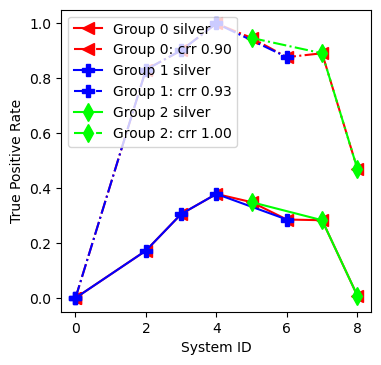

[0.    1.771 0.832 0.902 1.    0.947 0.877 0.891 0.471]
28070


In [11]:
def obj_func_single(inputs, variables):
    bronze = np.nanmean(inputs[variables.astype(bool)], 0)
    return stats.pearsonr(bronze[tuning], known_robustness[tuning])[0] + bronze[tuning].mean() * 1e-0 + bronze[tuning].std() * 1e-0 - variables.sum() / len(variables) #- max(1200, len(variables))  * 1e-2

algorithm = GA(
    pop_size=280,
    sampling=BinaryRandomSampling(),
    crossover=TwoPointCrossover(),
    mutation=BitflipMutation(),
    eliminate_duplicates=True)


releases = []

# for r in range(5):
df_ = df
res = minimize(
    MyProblem(df_.values.astype(int)),
    algorithm,
    ('n_gen', 100),
    verbose=False)

predicted_robustness = df_.values[res.X.astype(bool)].mean(0)
predicted_robustness = (predicted_robustness - predicted_robustness[indices].min())/ (predicted_robustness[indices].max() - predicted_robustness[indices].min())
crr = show_crr(known_robustness, predicted_robustness, indices, tuning, testing)
print(np.round(predicted_robustness, 3))
print(res.X.sum())
releases.append(list(df_[res.X].index))


In [12]:
pd.DataFrame(releases[0]).to_csv(f'RobFace-01/{pname}.csv', index=False)

In [13]:
df

FaceNet  \
image_0_A.jpg    image_0_A_0.1_illum.png    image_0_B.jpg    True     False   
                 image_0_A_0.2_illum.png    image_0_B.jpg    True      True   
                 image_0_A_0.3_illum.png    image_0_B.jpg    True      True   
                 image_0_A_0.4_illum.png    image_0_B.jpg    True      True   
                 image_0_A_0.5_illum.png    image_0_B.jpg    True      True   
...                                                                     ...   
image_5999_A.jpg image_5999_A_0.5_illum.png image_5999_B.jpg False     True   
                 image_5999_A_0.6_illum.png image_5999_B.jpg False     True   
                 image_5999_A_0.7_illum.png image_5999_B.jpg False     True   
                 image_5999_A_0.8_illum.png image_5999_B.jpg False     True   
                 image_5999_A_0.9_illum.png image_5999_B.jpg False     True   

                                                                     r50  \
image_0_A.jpg    image_0_A_0.1_illum.png    image_0_B.jpg    True   True   
                 image_0_A_0.2_illum.png    image_0_B.jpg    True   True   
                 image_0_A_0.3_illum.png    image_0_B.jpg    True   True   
                 image_0_A_0.4_illum.png    image_0_B.jpg    True   True   
                 image_0_A_0.5_illum.png    image_0_B.jpg    True   True   
...                                                                  ...   
image_5999_A.jpg image_5999_A_0.5_illum.png image_5999_B.jpg False  True   
                 image_5999_A_0.6_illum.png image_5999_B.jpg False  True   
                 image_5999_A_0.7_illum.png image_5999_B.jpg False  True   
                 image_5999_A_0.8_illum.png image_5999_B.jpg False  True   
                 image_5999_A_0.9_illum.png image_5999_B.jpg False  True   

                                                                    EfficientNet  \
image_0_A.jpg    image_0_A_0.1_illum.png    image_0_B.jpg    True          False   
                 image_0_A_0.2_illum.png    image_0_B.jpg    True           True   
                 image_0_A_0.3_illum.png    image_0_B.jpg    True           True   
                 image_0_A_0.4_illum.png    image_0_B.jpg    True           True   
                 image_0_A_0.5_illum.png    image_0_B.jpg    True           True   
...                                                                          ...   
image_5999_A.jpg image_5999_A_0.5_illum.png image_5999_B.jpg False          True   
                 image_5999_A_0.6_illum.png image_5999_B.jpg False          True   
                 image_5999_A_0.7_illum.png image_5999_B.jpg False          True   
                 image_5999_A_0.8_illum.png image_5999_B.jpg False          True   
                 image_5999_A_0.9_illum.png image_5999_B.jpg False          True   

                                                                    ReXNet  \
image_0_A.jpg    image_0_A_0.1_illum.png    image_0_B.jpg    True    False   
                 image_0_A_0.2_illum.png    image_0_B.jpg    True     True   
                 image_0_A_0.3_illum.png    image_0_B.jpg    True     True   
                 image_0_A_0.4_illum.png    image_0_B.jpg    True     True   
                 image_0_A_0.5_illum.png    image_0_B.jpg    True     True   
...                                                                    ...   
image_5999_A.jpg image_5999_A_0.5_illum.png image_5999_B.jpg False    True   
                 image_5999_A_0.6_illum.png image_5999_B.jpg False    True   
                 image_5999_A_0.7_illum.png image_5999_B.jpg False    True   
                 image_5999_A_0.8_illum.png image_5999_B.jpg False    True   
                 image_5999_A_0.9_illum.png image_5999_B.jpg False    True   

                                                                    AttentionNet  \
image_0_A.jpg    image_0_A_0.1_illum.png    image_0_B.jpg    True          False   
                 image_0_A_0.2_illum.png    image_0_B.jpg    True           True   
        